# Кластеризация уровня здоровья жителей различных городов с помощью k-means

Датасет представляет собой набор данных внимания к здоровью жителей 53 различных городов.

Характеристики:
* Уровень смертности
* Доступность приема доктора
* Доступность больницы
* ВВП
* Плотность населения

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('health_data_ram.csv')

In [6]:
df = df.drop(['State','special_assitance_area'],axis=1)
df = df.fillna(0)

In [7]:
df.head()

,City ID,death_rate,doctor_availability_rate,hospital_availability_rate,annual_per_capita,population_density
0,1001,0.0,119,190,7.2,108
1,1002,12.8,68,205,8.7,106
2,1003,11.9,176,603,9.5,186
3,1004,11.7,89,1357,7.7,182
4,1005,11.6,140,284,7.8,179


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   City ID                     53 non-null     int64  
 1   death_rate                  53 non-null     float64
 2   doctor_availability_rate    53 non-null     int64  
 3   hospital_availability_rate  53 non-null     int64  
 4   annual_per_capita           53 non-null     float64
 5   population_density          53 non-null     int64  
dtypes: float64(2), int64(4)
memory usage: 2.6 KB


In [9]:
df.shape

(53, 6)

In [10]:
corr = df.iloc[:,1:].corr()

<AxesSubplot:>

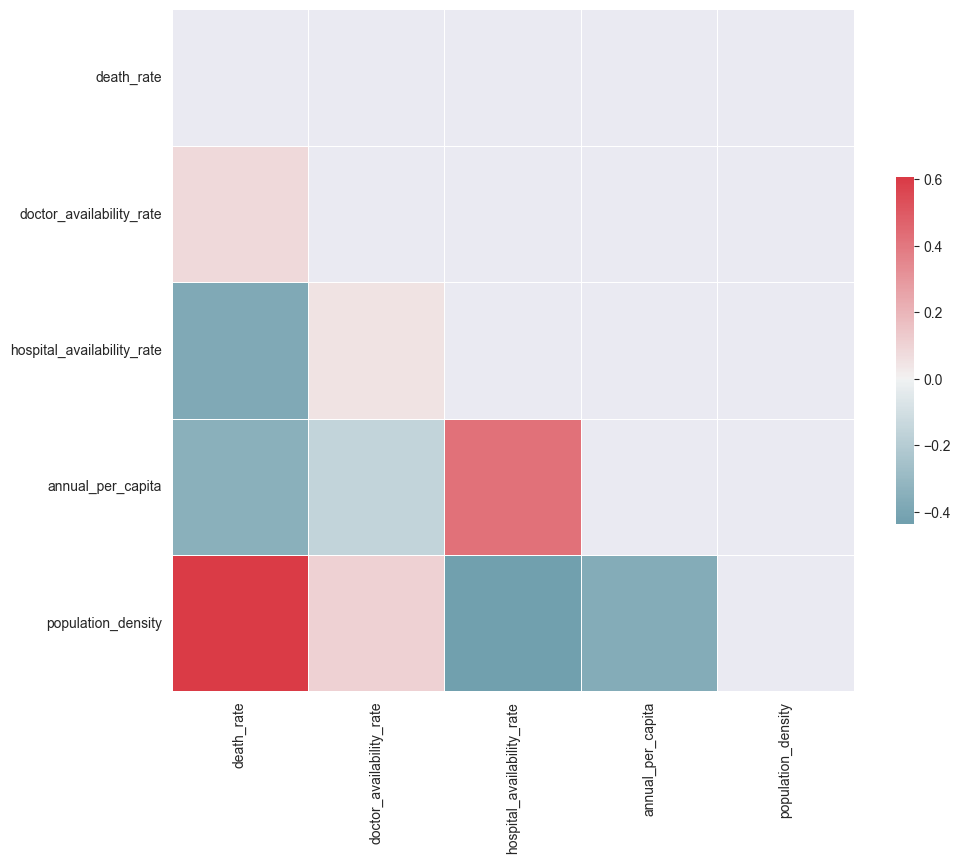

In [11]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Нормализация данных

In [12]:
df_scale = df.copy()
scaler = preprocessing.StandardScaler()
columns = df.columns[1:6]
df_scale[columns] = scaler.fit_transform(df_scale[columns])
df_scale.head()

,City ID,death_rate,doctor_availability_rate,hospital_availability_rate,annual_per_capita,population_density
0,1001,-4.394856,0.077428,-1.213458,-2.098901,-0.049501
1,1002,1.767753,-1.281577,-1.167930,-0.690778,-0.092160
2,1003,1.334445,1.596314,0.040088,0.060222,1.614210
3,1004,1.238154,-0.721987,2.328643,-1.629526,1.528892
4,1005,1.190009,0.637017,-0.928147,-1.535651,1.464903


### k-means

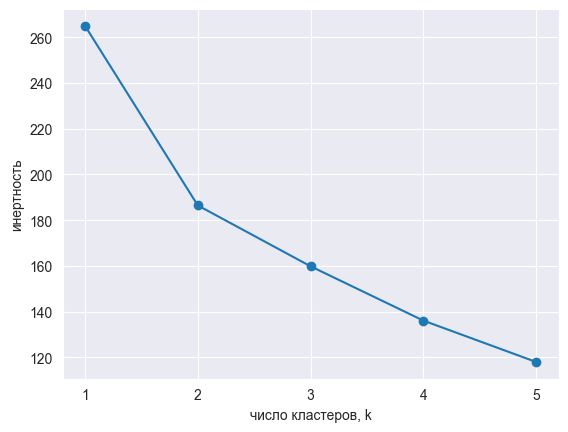

In [15]:
ks = range(1, 6)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, init='random')

    model.fit(df_scale.iloc[:,1:])

    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('число кластеров, k')
plt.ylabel('инертность')
plt.xticks(ks)
plt.show()

Инерция - показатель качества кластера: инерция показывает, как далеко находятся точки в кластере. Качественная кластеризация - это когда точки данных внутри кластера находятся близко друг к другу и вдали от других кластеров.

In [16]:
model = KMeans(n_clusters=3, init='random')

model.fit(df_scale.iloc[:,1:6])

df_scale['cluster'] = model.predict(df_scale.iloc[:,1:6])

df_scale.head()

,City ID,death_rate,doctor_availability_rate,hospital_availability_rate,annual_per_capita,population_density,cluster
0,1001,-4.394856,0.077428,-1.213458,-2.098901,-0.049501,0
1,1002,1.767753,-1.281577,-1.167930,-0.690778,-0.092160,1
2,1003,1.334445,1.596314,0.040088,0.060222,1.614210,1
3,1004,1.238154,-0.721987,2.328643,-1.629526,1.528892,1
4,1005,1.190009,0.637017,-0.928147,-1.535651,1.464903,1


<AxesSubplot:>

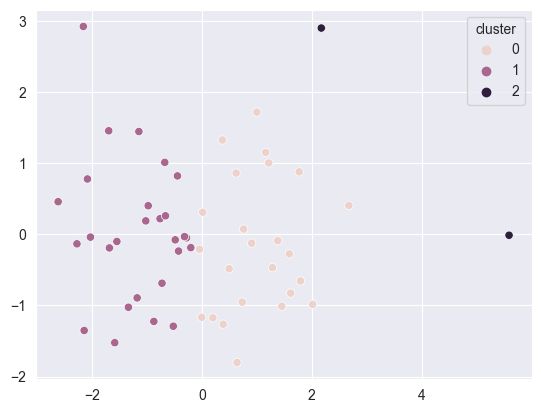

In [17]:
model_pca = PCA()

pca_features = model_pca.fit_transform(df_scale.iloc[:,1:6])
xs = pca_features[:,0]
ys = pca_features[:,1]

sns.scatterplot(x=xs, y=ys, hue="cluster", data=df_scale)

### Центроиды модели кластеризации

In [18]:
centroids = model.cluster_centers_
df_scale.iloc[:,1:10].groupby(['cluster']).mean()

,death_rate,doctor_availability_rate,hospital_availability_rate,annual_per_capita,population_density
cluster,,,,,
0,-0.627480,-0.205698,0.199057,0.400518,-0.702721
1,0.671108,0.135656,-0.429247,-0.509981,0.708096
2,-1.530206,0.637017,3.406146,2.078532,-1.126647


<AxesSubplot:ylabel='cluster'>

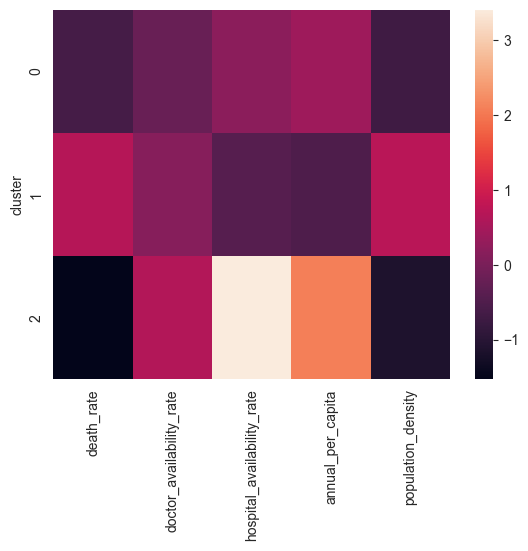

In [20]:
sns.heatmap(df_scale.iloc[:,1:7].groupby(['cluster']).mean())

In [21]:
pd.DataFrame(df_scale['cluster'].value_counts(dropna=False))

,cluster
1,27
0,24
2,2


### k-means++

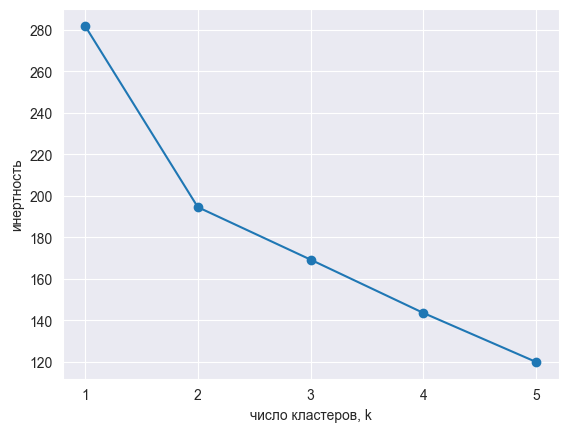

In [22]:
ks = range(1, 6)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, init='k-means++')

    model.fit(df_scale.iloc[:,1:])

    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('число кластеров, k')
plt.ylabel('инертность')
plt.xticks(ks)
plt.show()

In [23]:
model = KMeans(n_clusters=3, init='k-means++')

model.fit(df_scale.iloc[:,1:6])

df_scale['cluster'] = model.predict(df_scale.iloc[:,1:6])

df_scale.head()

,City ID,death_rate,doctor_availability_rate,hospital_availability_rate,annual_per_capita,population_density,cluster
0,1001,-4.394856,0.077428,-1.213458,-2.098901,-0.049501,0
1,1002,1.767753,-1.281577,-1.167930,-0.690778,-0.092160,0
2,1003,1.334445,1.596314,0.040088,0.060222,1.614210,1
3,1004,1.238154,-0.721987,2.328643,-1.629526,1.528892,1
4,1005,1.190009,0.637017,-0.928147,-1.535651,1.464903,1


<AxesSubplot:>

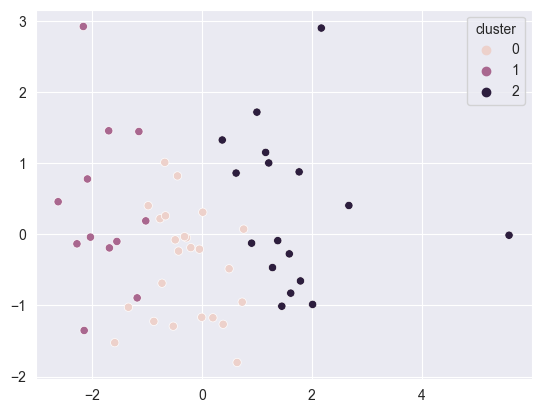

In [24]:
model_pca = PCA()

pca_features = model_pca.fit_transform(df_scale.iloc[:,1:6])
xs = pca_features[:,0]
ys = pca_features[:,1]

sns.scatterplot(x=xs, y=ys, hue="cluster", data=df_scale)

In [25]:
centroids = model.cluster_centers_
df_scale.iloc[:,1:10].groupby(['cluster']).mean()

,death_rate,doctor_availability_rate,hospital_availability_rate,annual_per_capita,population_density
cluster,,,,,
0,0.084671,-0.346706,-0.437074,-0.264429,-0.068164
1,0.929221,0.514885,-0.454906,-0.596903,1.432908
2,-0.775456,0.126019,0.938156,0.794655,-0.915233


<AxesSubplot:ylabel='cluster'>

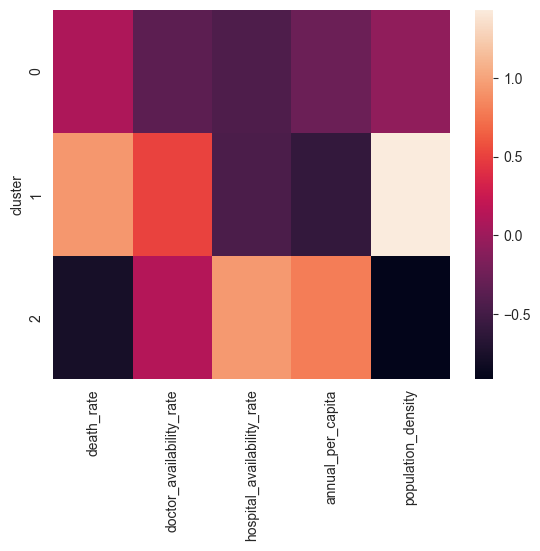

In [26]:
sns.heatmap(df_scale.iloc[:,1:7].groupby(['cluster']).mean())

In [27]:
pd.DataFrame(df_scale['cluster'].value_counts(dropna=False))

,cluster
0,24
2,17
1,12


* Кластер 0: Города с низкой смертностью, хорошим больничным обслуживанием, низким уровнем населения и хорошими зарплатами.
* Кластер 1: Города с высоким уровнем смертности, больничной службой скорой помощи и высокой плотностью населения.
* Кластер 2: Города со средним уровнем смертности, худшим медицинским обслуживанием и средней численностью населения.